<a href="https://colab.research.google.com/github/TheLayman/HandsOnML/blob/main/karpathy_micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

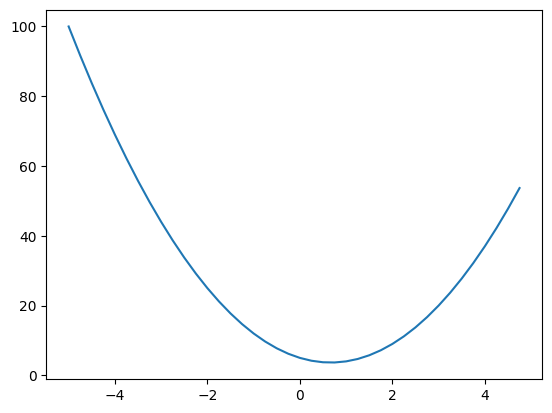

In [3]:
xs=np.arange(-5,5, 0.25)
ys=f(xs)
plt.plot(xs,ys)

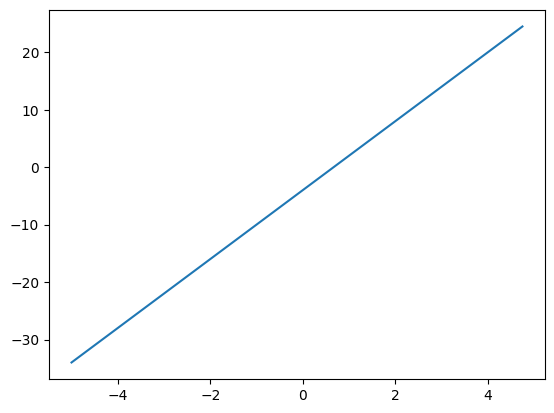

In [4]:
def dev_f(x):
  return 6*x - 4
dev_ys=dev_f(xs)
plt.plot(xs, dev_ys)

In [5]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data=data
    self._prev = set(_children)
    self._op = _op
    self.label=label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out=Value(self.data+other.data, (self, other), "+")
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __rmul__(self, other):
    return self * other

  def __radd__(self, other):
    return self + other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    out = Value(math.exp(self.data), (self,) , "exp")
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out= Value(self.data*other.data, (self, other), "*")
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def tanh (self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self,), "tanh")
    def _backward():
      self.grad += (1 - (out.data)**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f| grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [7]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

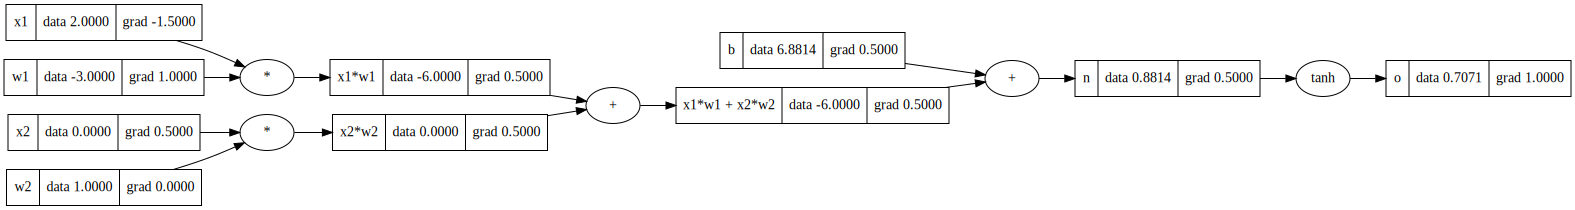

In [8]:
o.backward()
draw_dot(o)

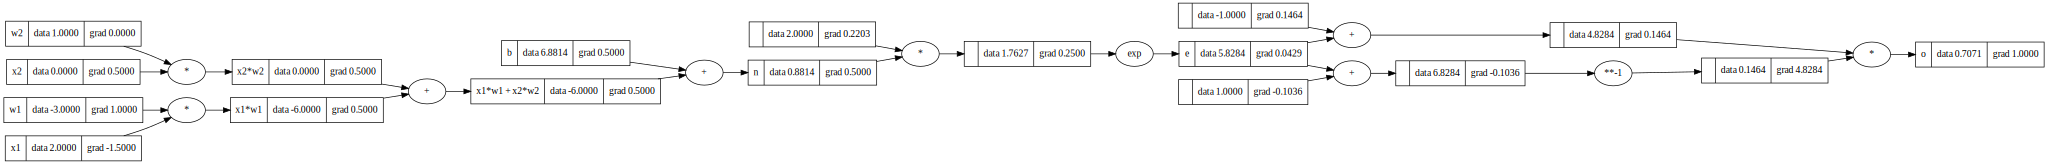

In [9]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp() ; e.label = 'e'
o = (e-1)/(e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

In [10]:
import torch

In [11]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('b', b.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
b 0.5000001283844369


In [12]:
import random

In [93]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [99]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.10074600451473674)

In [100]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x_) for x_ in xs]
ypred

[Value(data=0.10074600451473674),
 Value(data=-0.5249007926740352),
 Value(data=-0.5058421165147208),
 Value(data=-0.28486033717631604)]

In [103]:
for k in range(40):
  # forward_pass
  ypred = [n(x_) for x_ in xs]
  loss = -1.0 * sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred))

  #backward_pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  #update weights
  for p in n.parameters():
    p.data += 0.05*p.grad

  print(k, loss.data)

ypred

0 -0.031548647911680924
1 -0.030631224603417155
2 -0.02976284446523161
3 -0.028939765811513023
4 -0.028158613252119612
5 -0.02741633432000249
6 -0.026710162081193773
7 -0.026037582790667
8 -0.025396307820820373
9 -0.02478424922134532
10 -0.024199498376510226
11 -0.02364030731344778
12 -0.02310507228680926
13 -0.022592319324241567
14 -0.022100691465980777
15 -0.021628937472376427
16 -0.021175901806907923
17 -0.020740515730452335
18 -0.020321789366214735
19 -0.019918804614627604
20 -0.01953070881431808
21 -0.01915670905946034
22 -0.018796067095899788
23 -0.01844809472871539
24 -0.018112149682662712
25 -0.017787631864453587
26 -0.017473979982277454
27 -0.01717066848351952
28 -0.01687720477641513
29 -0.01659312670552033
30 -0.01631800025446178
31 -0.01605141745254486
32 -0.015792994464506972
33 -0.015542369845067027
34 -0.01529920294198594
35 -0.015063172433162152
36 -0.0148339749848693
37 -0.014611324019639937
38 -0.014394948583521784
39 -0.014184592303518928


[Value(data=0.9531418571469399),
 Value(data=-0.9294458025444269),
 Value(data=-0.954567447591711),
 Value(data=0.9296658322367485)]